# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Luis Antonio Pelayo Sierra

**Professor**: Pablo Camarillo Ramirez

# Introduction

El objetivo de este pipeline es el de analizar una coleccion de tweets con el fin de encontrar tendencias, desde la popularidad propia de los tweets, hasta encontrar patrones ya sea entre las fechas, usuarios o contenidos de los tweets.

# Dataset

El dataset utilizado para esta actividad sera el Twitter-Dataset de Kaggle (https://www.kaggle.com/datasets/goyaladi/twitter-dataset/data), el cual consiste en informacion de 10,000 tweets del primer semestre de 2023, lo que incluye una gran variedad de usuarios, texto, cuentas de retweets y likes, ademas de los timestamps asociados a cada tweet. 

In [188]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Final Project - Batch Processing") \
    .master("spark://spark-master:7077") \
    .config("spark.ui.port", "4040") \
    .config("spark.jars", "/opt/spark/work-dir/jars/postgresql-42.7.8.jar") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [211]:
from luis_pelayo.spark_utils import SparkUtils

schema = SparkUtils.generate_schema([
    ("Tweet_ID","int"),
    ("Username","string"),
    ("Text", "string"),
    ("Retweets", "int"),
    ("Likes", "int"),
    ("Timestamp", "string")
])

df = spark.read \
                .option("header", "true") \
                .schema(schema) \
                .csv("/opt/spark/work-dir/data/final_project/") 

# Transformations and Actions

In [190]:
# Convertir el timestamp y sumar likes con retweets
from pyspark.sql.functions import to_timestamp, col

df = df.withColumn("Timestamp", to_timestamp(col("Timestamp")))

df = df.withColumn("Engagement", col("Likes") + col("Retweets"))

df = df.dropna()
# df.printSchema()

In [191]:
# Tabla 1: Dataframe ordenado por interacciones
df_sorted_by_engagement = df.orderBy(col("Engagement").desc())

In [192]:
# Tabla 2: Interacciones agrupadas por dia
from pyspark.sql.functions import to_date, sum, avg, count

tweets_by_date = (df.withColumn("Date", to_date(col("Timestamp")))
                    .groupBy("Date")
                    .agg(count("Tweet_ID").alias("tweets_count"),
                            sum("Likes").alias("likes_sum"),
                            sum("Retweets").alias("retweets_sum"),
                            sum("Engagement").alias("engagement_sum"),
                            avg("Likes").alias("likes_avg"),
                            avg("Retweets").alias("retweets_avg"),
                            avg("Engagement").alias("engagement_avg"))
                    .orderBy("Date"))


In [193]:
# Tabla 3: Datos agrupados por usuario
from pyspark.sql.functions import length, avg

tweets_by_user = (df.withColumn("TextLength", length(col("Text"))) 
                    .groupBy("Username") 
                    .agg(count("Tweet_ID").alias("tweets_count"),
                            sum("Likes").alias("likes_sum"),
                            sum("Retweets").alias("retweets_sum"),
                            sum("Engagement").alias("engagement_sum"),
                            avg("TextLength").alias("Avg_Text_Length"))
                    .orderBy(col("engagement_sum").desc()))

In [194]:
# Tabla 4: Datos agrupados por semana
from pyspark.sql.functions import date_trunc

tweets_by_week = (df.withColumn("Week", date_trunc("week", col("Timestamp")))
                        .groupBy("Week")
                        .agg(count("Tweet_ID").alias("tweets_count"),
                                sum("Likes").alias("likes_sum"),
                                sum("Retweets").alias("retweets_sum"),
                                sum("Engagement").alias("engagement_sum"))
                        .orderBy("Week"))

In [195]:
# Tabla 5: Datos agrupados por mes
tweets_by_month = (df.withColumn("Month", date_trunc("month", col("Timestamp")))
                        .groupBy("Month")
                        .agg(count("Tweet_ID").alias("tweets_count"),
                                sum("Likes").alias("likes_sum"),
                                sum("Retweets").alias("retweets_sum"),
                                sum("Engagement").alias("engagement_sum"))
                        .orderBy("Month"))

In [196]:
# Tabla 6: Datos agrupados por hora del día
from pyspark.sql.functions import hour

df_hour = (df.withColumn("Hour", hour("Timestamp"))
            .groupBy("Hour")
            .agg(count("Tweet_ID").alias("tweets_count"),
                    sum("Likes").alias("likes_sum"),
                    sum("Retweets").alias("retweets_sum"),
                    sum("Engagement").alias("engagement_sum"))
            .orderBy(col("tweets_count").desc()))


In [197]:
# Tabla 7: Resumen de dataset
from pyspark.sql.functions import countDistinct
df_summary = df.agg(count("*").alias("Total_Posts"),
                    countDistinct("Username").alias("Unique_Users_Count"),
                    sum("Likes").alias("Total_Likes"),
                    sum("Retweets").alias("Total_Retweets"))

In [198]:
# Tabla 8: Conteo de palabras en tweets
from pyspark.sql.functions import split, explode, lower, trim, regexp_replace

df_words = df.select(explode(split(lower(col("Text")), " ")).alias("Word"))
df_words = df_words.withColumn("Word", trim(regexp_replace(col("Word"), r"[^a-zA-Z0-9]", "")))
df_word_count = df_words.groupBy("Word").count().orderBy(col("count").desc())


In [199]:
# ~ Tabla 9: Conteo de hashtags en tweets ~ (El dataset no contiene hashtags, agregue unos manualmente para probar)
df_hashtags = (df.select(explode(split(col("Text"), " ")).alias("Tags")) 
                .filter(col("Tags").startswith("#")) 
                .groupBy("Tags") 
                .count() 
                .orderBy(col("count").desc()))


In [200]:
# Tabla 10: Estadísticas de engagement por palabra
df_words_with_engagement = df.select("Tweet_ID", "Engagement", explode(split(lower(col("Text")), " ")).alias("Word"))
df_words_with_engagement = df_words_with_engagement.withColumn("Word", trim(regexp_replace(col("Word"), r"[^a-zA-Z0-9]", "")))

avg_when_word = df_words_with_engagement.groupBy("Word").agg(avg("Engagement").alias("Engagement_When_Word"))
avg_total = df.agg(avg("Engagement").alias("AvgEngagement_Total")).collect()[0][0]

count_word = df_words_with_engagement.groupBy("Word").agg(countDistinct("Tweet_ID").alias("CountWithWord"))

total_tweets = df.select(countDistinct("Tweet_ID")).collect()[0][0]

df_word_stats = (avg_when_word.join(count_word, "Word") 
                                .withColumn("Engagement_When_No_Word", (avg_total*total_tweets - col("Engagement_When_Word")*col("CountWithWord")) / (total_tweets - col("CountWithWord"))))

# Persistence Data

Justificacion: Postgres es una base de datos de tipo relacional, la que lo vuelve excepcional para el manejo de datos normalizados, ademas de soportar agregaciones y funciones analiticas. Debido a que estamos trabajando con una muestra, no se requieren de varias instancias, en el caso de que los analisis se aplicaran sobre la totalidad de los tweets, quiza seria mas adecuado utilizar otra base de datos.

In [201]:
df_sorted_by_engagement.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://postgres-iteso:5432/postgres") \
    .option("dbtable", "tweets") \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .option("batchsize", 500) \
    .save()

print("tweets table was successfully written into a PosgreSQL DB!")

tweets table was successfully written into a PosgreSQL DB!


In [202]:
tweets_by_date.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://postgres-iteso:5432/postgres") \
    .option("dbtable", "tweets_by_date") \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("tweets_by_date table was successfully written into a PosgreSQL DB!")

tweets_by_date table was successfully written into a PosgreSQL DB!


In [203]:
tweets_by_user.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://postgres-iteso:5432/postgres") \
    .option("dbtable", "tweets_by_user") \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("tweets_by_user table was successfully written into a PosgreSQL DB!")

tweets_by_user table was successfully written into a PosgreSQL DB!


In [204]:
tweets_by_month.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://postgres-iteso:5432/postgres") \
    .option("dbtable", "tweets_by_month") \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("tweets_by_month table was successfully written into a PosgreSQL DB!")

tweets_by_month table was successfully written into a PosgreSQL DB!


In [205]:
tweets_by_week.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://postgres-iteso:5432/postgres") \
    .option("dbtable", "tweets_by_week") \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("tweets_by_week table was successfully written into a PosgreSQL DB!")

tweets_by_week table was successfully written into a PosgreSQL DB!


In [206]:
df_hour.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://postgres-iteso:5432/postgres") \
    .option("dbtable", "tweets_by_hour") \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("tweets_by_hour table was successfully written into a PosgreSQL DB!")

tweets_by_hour table was successfully written into a PosgreSQL DB!


In [207]:
df_summary.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://postgres-iteso:5432/postgres") \
    .option("dbtable", "tweets_summary") \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("tweets_summary table was successfully written into a PosgreSQL DB!")

tweets_summary table was successfully written into a PosgreSQL DB!


In [208]:
df_word_count.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://postgres-iteso:5432/postgres") \
    .option("dbtable", "word_count") \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("word_count table was successfully written into a PosgreSQL DB!")

word_count table was successfully written into a PosgreSQL DB!


In [209]:
df_hashtags.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://postgres-iteso:5432/postgres") \
    .option("dbtable", "hashtags") \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("hashtags table was successfully written into a PosgreSQL DB!")

hashtags table was successfully written into a PosgreSQL DB!


In [210]:
df_word_stats.write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://postgres-iteso:5432/postgres") \
    .option("dbtable", "word_stats") \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("word_stats table was successfully written into a PosgreSQL DB!")

word_stats table was successfully written into a PosgreSQL DB!


In [173]:
sc.stop()

# DAG

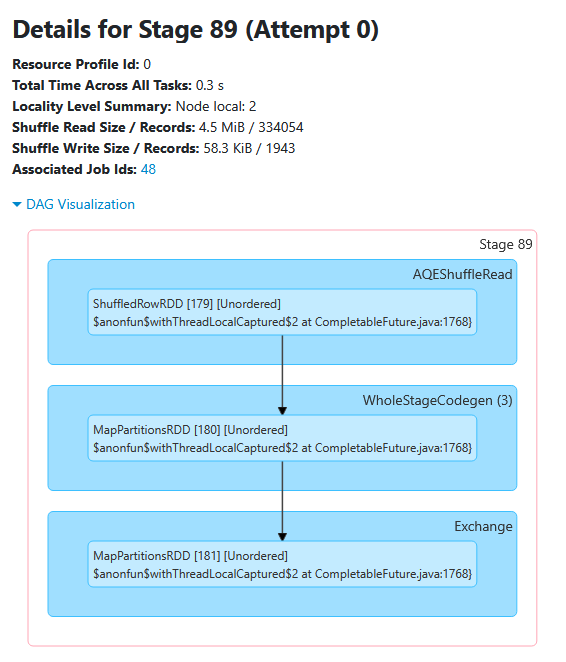